# Image Classification with Convolutional Neural Networks
Steps:

1.   Explore the Data of bikes and no bikes
2.   Build and Train a Neural Network to recognize the difference between the two
3.   Evaluate the Training and Validation accuracy or F1-score

## Preliminaries

### Libraries 

In [ ]:
# Importing necessary libraries
from google.colab import files

import pathlib
import os
import random
import glob

import keras
from keras import backend as K
from keras.preprocessing import image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

from PIL import Image

from skimage import io
from skimage.morphology import binary_closing, binary_dilation, binary_erosion, binary_opening
from skimage.morphology import selem
from skimage import transform

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import itertools

import numpy as np
import pandas as pd
import cv2

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

### Functions

In [ ]:
def plot_image(images, captions=None, cmap=None ):
    '''
    function to plot n images using subplots
    '''
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

def ConvertImages_to_JPG(path):
    '''
    change the image format to jpg
    '''
    names = []
    for file in os.listdir(path):
        if (file.endswith('.png') or file.endswith('.bmp') or file.endswith('.gif')):
            names.append(file)
    
    for i in range(len(names)):
        im_dir = os.path.join(path, names[i])
        im = Image.open(im_dir)
        rgb_im = im.convert('RGB')
        rgb_im.save(path + 'rgb_' + str(i) + '.jpg', "JPEG")

    for i in range(len(names)):
        im_remove = os.path.join(path, names[i])
        os.remove(im_remove)


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()    

## Configure Environment

### Drive mount

In [ ]:
from google.colab import drive
drive.mount('/drive', force_remount=True)

Mounted at /drive


###Cambio de formato png a jpeg

In [ ]:
#Convierte Imagener a jpg desde directorio de origen
path_images = "/drive/MyDrive/Proyectos/Reconocimiento_Bicicleta/data_bike"

dir_folders = ['train', 'validation', 'test']
class_ = ['bike', 'no_bike']

for folder in dir_folders:
    dir_ = os.path.join(path_images, folder)
    for clase in class_:
        dir_class_ = os.path.join(dir_, clase)
        ConvertImages_to_JPG(dir_class_)

### Get Data and Create Directory

In [ ]:
%rm -r /tmp/*

!cp -r /drive/MyDrive/Proyectos/Reconocimiento_Bicicleta/data_bike /tmp

### Define each of these directories.

In [ ]:
base_dir = '/tmp/data_bike'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training cat/dog pictures
train_bikes_dir = os.path.join(train_dir, 'bike')
train_nobikes_dir = os.path.join(train_dir, 'no_bike')

# Directory with our validation cat/dog pictures
validation_bikes_dir = os.path.join(validation_dir, 'bike')
validation_nobikes_dir = os.path.join(validation_dir, 'no_bike')

# Directory with our validation cat/dog pictures
test_bikes_dir = os.path.join(test_dir, 'bike')
test_nobikes_dir = os.path.join(test_dir, 'no_bike')

### Filenames look like in the `bikes` and `no_bikes` `train` directories.

In [ ]:
# Filenames look like in the bikes and no_bikes train directories.
train_bikes_fnames = os.listdir(train_bikes_dir)
train_nobikes_fnames = os.listdir(train_nobikes_dir)

print(train_bikes_fnames[:5])
print(train_nobikes_fnames[:5])

['bicicleta (57).jpg', 'bicicleta (1046).jpg', 'bicicleta_2 (674).jpg', 'bicicleta (249).jpg', 'bicicleta (506).jpg']
['moto (67).jpeg', 'electric-scooter-on-white-background-vector-id1161542713.jpg', 'two-boys-in-park-help-boy-with-roller-skates-to-stand-up-picture-id990361064.jpg', '01130.jpg', 'moto (128).jpg']


### Total number of bikes and no bikes images in the `train` and `validation` directories.

In [ ]:
print('total training bikes images :', len(os.listdir(train_bikes_dir)))
print('total training no_bikes images :', len(os.listdir(train_nobikes_dir)))

print('total validation bikes images :', len(os.listdir(validation_bikes_dir)))
print('total validation no_bikes images :', len(os.listdir(validation_nobikes_dir)))

print('total test bikes images :', len(os.listdir(test_bikes_dir)))
print('total test no_bikes images :', len(os.listdir(test_nobikes_dir)))

total training bikes images : 2438
total training no_bikes images : 2533
total validation bikes images : 656
total validation no_bikes images : 885
total test bikes images : 204
total test no_bikes images : 145


### Look at a few pictures.

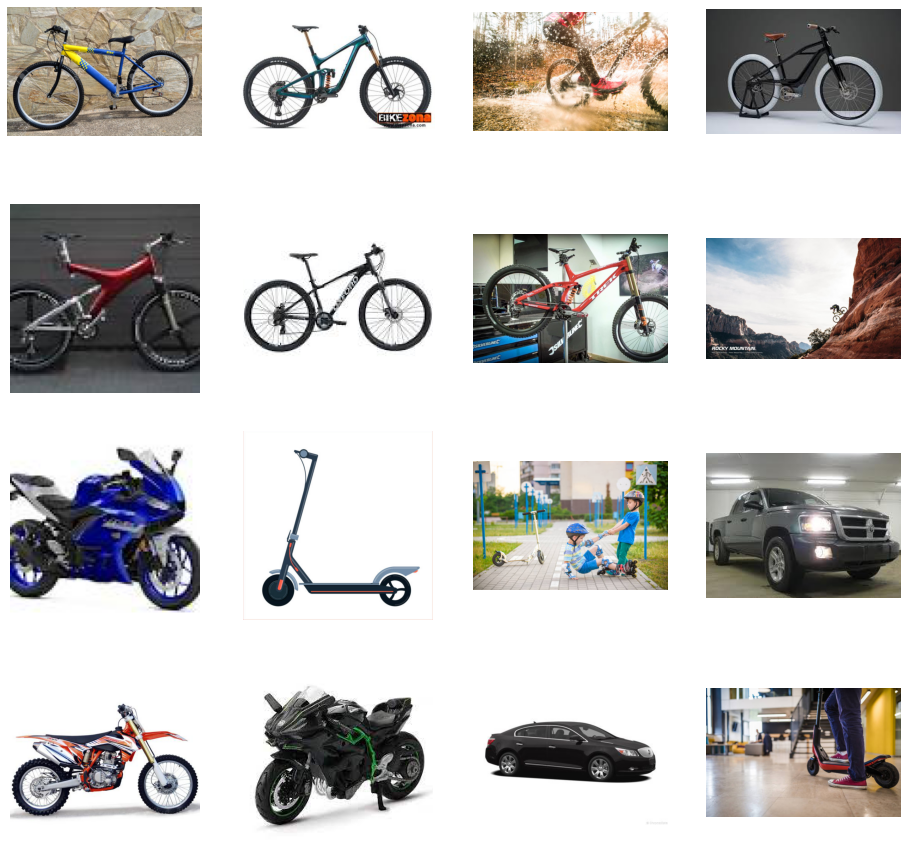

In [ ]:
nrows = 4
ncols = 4

pic_index = 0 

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_bike_pix = [os.path.join(train_bikes_dir, fname) 
                for fname in train_bikes_fnames[ pic_index-8:pic_index] 
               ]

next_nobike_pix = [os.path.join(train_nobikes_dir, fname) 
                for fname in train_nobikes_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_bike_pix + next_nobike_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

## Data Preprocessing

In [ ]:
# glob through the directory (returns a list of all file paths)
bike_path = os.path.join(train_bikes_dir, '*')
bike_path = glob.glob(bike_path)

# access some element (a file) from the list
image = io.imread(bike_path[10])

### Images — Channels and Sizes
plotting the original image and the RGB channels

Text(0.5, 0.98, 'Different Channels of Image')

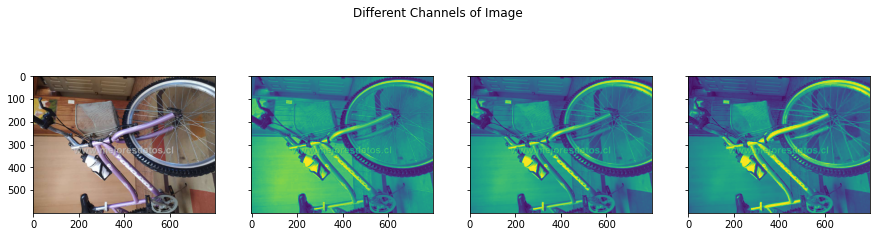

In [ ]:
# plotting the original image and the RGB channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)
ax1.imshow(image)

# RGB channels
# CHANNELID : 0 for Red, 1 for Green, 2 for Blue. 
ax2.imshow(image[:, : , 0]) #Red
ax3.imshow(image[:, : , 1]) #Green
ax4.imshow(image[:, : , 2]) #Blue
f.suptitle('Different Channels of Image')

### Morphological Transformations

#### 1. Thresholding
One of the simpler operations where we take all the pixels whose intensities are above a certain threshold and convert them to ones; the pixels having value less than the threshold are converted to zero. This results in a binary image.

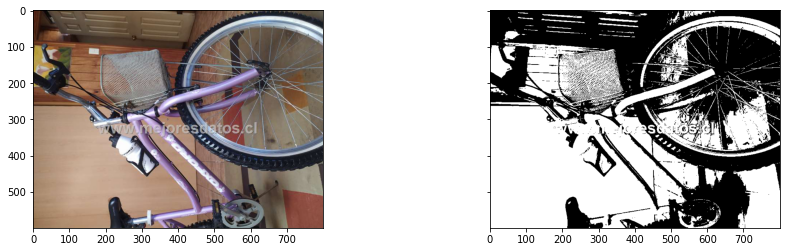

In [ ]:
# bin_image will be a (240, 320) True/False array
#The range of pixel varies between 0 to 255
#The pixel having black is more close to 0 and pixel which is white is more close to 255
# 125 is Arbitrary heuristic measure halfway between 1 and 255 (the range of image pixel) 
bin_image = image[:, :, 0] > 125
plot_image([image, bin_image], cmap='gray')

#### 2. Erosion, Dilation, Opening & Closing

- Erosion shrinks bright regions and enlarges dark regions. Dilation on the other hand is exact opposite side — it shrinks dark regions and enlarges the bright regions.
- Opening is erosion followed by dilation. Opening can remove small bright spots (i.e. “salt”) and connect small dark cracks. This tends to “open” up (dark) gaps between (bright) features.
- Closing is dilation followed by erosion. Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks. This tends to “close” up (dark) gaps between (bright) features.

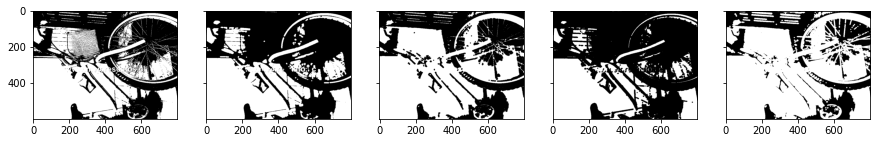

In [ ]:
# use a disk of radius 3
selem = selem.disk(3)

# oprning and closing
open_img = binary_opening(bin_image, selem)
close_img = binary_closing(bin_image, selem)

# erosion and dilation
eroded_img = binary_erosion(bin_image, selem)
dilated_img = binary_dilation(bin_image, selem)

plot_image([bin_image, open_img, close_img, eroded_img, dilated_img], cmap='gray')

#### 3. Normalization
Normalization is the most crucial step in the pre-processing part. This refers to rescaling the pixel values so that they lie within a confined range. One of the reasons to do this is to help with the issue of propagating gradients. There are multiple ways to normalize images that we will be talking about.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


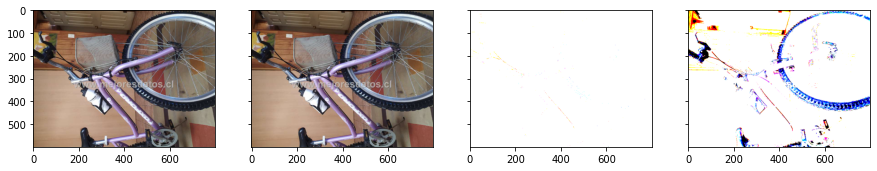

In [ ]:
#way1-this is common technique followed in case of RGB images 
norm1_image = image/255
#way2-in case of medical Images/non natural images 
norm2_image = image - np.min(image)/np.max(image) - np.min(image)
#way3-in case of medical Images/non natural images 
norm3_image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)

plot_image([image, norm1_image, norm2_image, norm3_image], cmap='gray')

### Augmentation

#### 1. Linear Transform

##### flip left-right, up-down

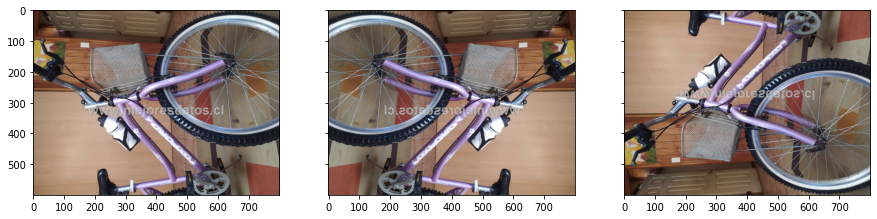

In [ ]:
# flip left-right, up-down
image_flipr = np.fliplr(image)
image_flipud = np.flipud(image)

plot_image([image, image_flipr, image_flipud])

#### 2. Affine transformations

##### shifting

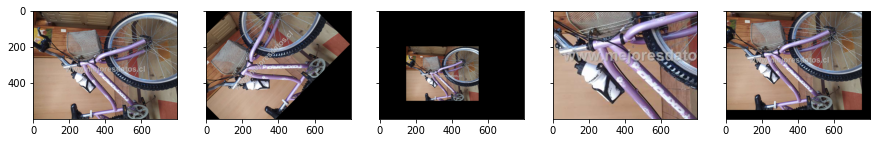

In [ ]:
# specify x and y coordinates to be used for shifting (mid points)
shift_x, shift_y = image.shape[0]/2, image.shape[1]/2

# translation by certain units
matrix_to_topleft = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
matrix_to_center = transform.SimilarityTransform(translation=[shift_x, shift_y])

# rotation
rot_transforms =  transform.AffineTransform(rotation=np.deg2rad(45))
rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
rot_image = transform.warp(image, rot_matrix)

# scaling 
scale_transforms = transform.AffineTransform(scale=(2, 2))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_out = transform.warp(image, scale_matrix)

scale_transforms = transform.AffineTransform(scale=(0.5, 0.5))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_in = transform.warp(image, scale_matrix)

# translation
transaltion_transforms = transform.AffineTransform(translation=(50, 50))
translated_image = transform.warp(image, transaltion_transforms)


plot_image([image, rot_image, scale_image_zoom_out, scale_image_zoom_in, translated_image])

##### shear transforms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


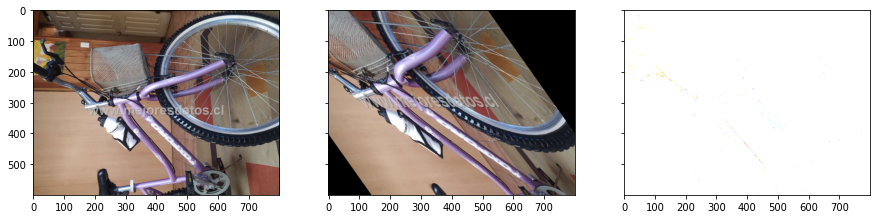

In [ ]:
# shear transforms
shear_transforms = transform.AffineTransform(shear=np.deg2rad(45))
shear_matrix = matrix_to_topleft + shear_transforms + matrix_to_center
shear_image = transform.warp(image, shear_matrix)

bright_jitter = image*0.999 + np.zeros_like(image)*0.001

plot_image([image, shear_image, bright_jitter])

### Searching the best dimensions

In [ ]:
path_images = "/tmp/data_bike"

dir_folders = ['train']
class_ = ['bike', 'no_bike']

min_ancho = 9999
min_alto = 9999

#### Looking for the smallest width 

Ancho minimo en las imagenes: 53

Imagen:



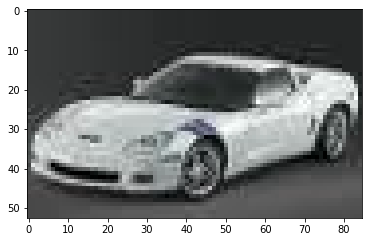

(53, 85, 3)


In [ ]:
#Busqueda del ancho mas chico
directorio = ''

for folder in dir_folders:
    dir_ = os.path.join(path_images, folder)
    for clase in class_:
        dir_class = os.path.join(dir_, clase)
        for filename in os.listdir(dir_class):
          img = cv2.imread(os.path.join(dir_class,filename))
          dim_image = img.shape[0]
          if dim_image < min_ancho:
            min_ancho = dim_image
            directorio = img

print('Ancho minimo en las imagenes: {}\n'.format(min_ancho))
print('Imagen:\n')
plt.imshow(directorio)
plt.show()
print(directorio.shape)

#### Looking for the smallest height

Alto minimo en las imagenes: 85

Imagen:



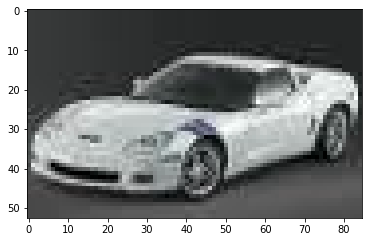

(53, 85, 3)


In [ ]:
#Busqueda alto mas chico
directorio = ''
for folder in dir_folders:
    dir_ = os.path.join(path_images, folder)
    for clase in class_:
        dir_class = os.path.join(dir_, clase)
        for filename in os.listdir(dir_class):
          img = cv2.imread(os.path.join(dir_class,filename))
          dim_image = img.shape[1]
          if dim_image < min_alto:
            min_alto = dim_image
            directorio = img

print('Alto minimo en las imagenes: {}\n'.format(min_alto))
print('Imagen:\n')
plt.imshow(directorio)
plt.show()
print(directorio.shape)

### ImageDataGenerator

#### ImageDataGenerator for Train

In [ ]:
# ImageDataGenerator for train data
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest').flow_from_directory(train_dir,
                                                                              target_size = (150, 159),
                                                                              batch_size = 20,
                                                                              shuffle=True,
                                                                              color_mode="rgb",
                                                                              class_mode = 'categorical',
                                                                              seed = 16626)
                                     
X_train, y_train = next(train_generator)                                  

print('-- Image Dimensions --', X_train[0].shape)                              

Found 4971 images belonging to 2 classes.
-- Image Dimensions -- (150, 159, 3)


#### ImageDataGenerator for Validation and Test

In [ ]:
# ImageDataGenerator for validation data
val_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(validation_dir,
                                                                         target_size = (150, 159),
                                                                         batch_size = 20,
                                                                         shuffle=True,
                                                                         color_mode="rgb",
                                                                         class_mode = 'categorical',
                                                                         seed = 16626)

X_val, y_val = next(val_generator)                                  

print('-- Image Dimensions --', X_val[0].shape)                                                                        

Found 1541 images belonging to 2 classes.
-- Image Dimensions -- (150, 159, 3)


In [ ]:
# ImageDataGenerator for test data
test_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_dir,
                                                                          target_size = (150, 159),
                                                                          batch_size = 20,
                                                                          shuffle=True,
                                                                          color_mode="rgb",
                                                                          class_mode = 'categorical',
                                                                          seed = 16626)  
                                                                          
X_test, y_test = next(test_generator)                                  

print('-- Image Dimensions --', X_test[0].shape)

Found 349 images belonging to 2 classes.
-- Image Dimensions -- (150, 159, 3)


## Modelling ConvNet

### Model Architecture

In [ ]:
i = Input(shape=X_train[0].shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)

model_ori = Model(i, x)

In [ ]:
#note: is necesary generate previusly X_train
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=X_train[0].shape),
                                    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2), 
                                    tf.keras.layers.Conv2D(32, (3,3), activation='relu'), 
                                    tf.keras.layers.Conv2D(32, (3,3), activation='relu'), 
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    tf.keras.layers.BatchNormalization(), 
                                    tf.keras.layers.MaxPooling2D(2,2),   
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),  
                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
                                    tf.keras.layers.BatchNormalization(),
                                    #tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.GlobalMaxPooling2D(),                                                                                                                                                                                                                    
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(2048, activation='relu'), 
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(2, activation='softmax')  
                                    ])

### Summary of the Model

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 148, 157, 32)      896       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 146, 155, 32)      9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 146, 155, 32)      128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 73, 77, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 71, 75, 32)        9248      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 69, 73, 32)        9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 69, 73, 32)       

### Early Stopping for Accuracy

In [ ]:
# Class for callback
class myCallback(tf.keras.callbacks.Callback):
    
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('acc') > accuracy_threshold):
			print("\nReached %2.2f%% accuracy, so stopping training!!" %(accuracy_threshold*100))
			self.model.stop_training = True

### Compile and Fit Model

In [ ]:
# Compile
# Note: make sure you are using the GPU for this!
model.compile(optimizer = Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['acc',
                       f1_m,
                       precision_m, 
                       recall_m,
                       tf.keras.metrics.AUC(name='auc')])

In [ ]:
# Step Size for train and valid
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = val_generator.n//val_generator.batch_size

# Threshold for early stopping
accuracy_threshold = 0.95

# Instantiate a callback object
callbacks = myCallback()

In [ ]:
# Fit
r = model.fit(train_generator, 
              validation_data = val_generator, 
              steps_per_epoch=step_size_train, 
              validation_steps=step_size_valid, 
              epochs=300,
              callbacks=[callbacks],
              verbose=2 )

Epoch 1/300
248/248 - 74s - loss: 0.6568 - acc: 0.6189 - f1_m: 0.6191 - precision_m: 0.6191 - recall_m: 0.6191 - auc: 0.6832 - val_loss: 0.7388 - val_acc: 0.4260 - val_f1_m: 0.4260 - val_precision_m: 0.4260 - val_recall_m: 0.4260 - val_auc: 0.3875
Epoch 2/300
248/248 - 72s - loss: 0.5716 - acc: 0.7203 - f1_m: 0.7203 - precision_m: 0.7203 - recall_m: 0.7203 - auc: 0.7916 - val_loss: 0.7754 - val_acc: 0.5273 - val_f1_m: 0.5273 - val_precision_m: 0.5273 - val_recall_m: 0.5273 - val_auc: 0.5285
Epoch 3/300
248/248 - 72s - loss: 0.5158 - acc: 0.7502 - f1_m: 0.7501 - precision_m: 0.7501 - recall_m: 0.7501 - auc: 0.8310 - val_loss: 0.6569 - val_acc: 0.7091 - val_f1_m: 0.7091 - val_precision_m: 0.7091 - val_recall_m: 0.7091 - val_auc: 0.7576
Epoch 4/300
248/248 - 72s - loss: 0.5078 - acc: 0.7520 - f1_m: 0.7523 - precision_m: 0.7523 - recall_m: 0.7523 - auc: 0.8375 - val_loss: 0.8198 - val_acc: 0.7013 - val_f1_m: 0.7013 - val_precision_m: 0.7013 - val_recall_m: 0.7013 - val_auc: 0.7476
Epoch 5/

In [ ]:
r.history.keys()

dict_keys(['loss', 'acc', 'f1_m', 'precision_m', 'recall_m', 'auc', 'val_loss', 'val_acc', 'val_f1_m', 'val_precision_m', 'val_recall_m', 'val_auc'])

### Performance Model

#### Plot Loss per iteration

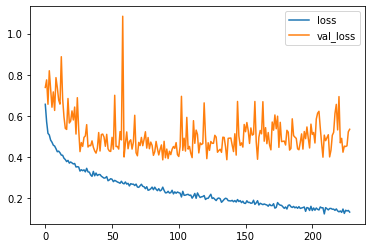

In [ ]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

#### Plot Accuracy per iteration

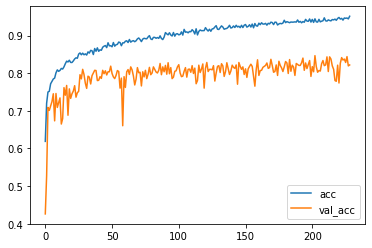

In [ ]:
# Plot accuracy per iteration
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend();

#### Plot F1-score per iteration

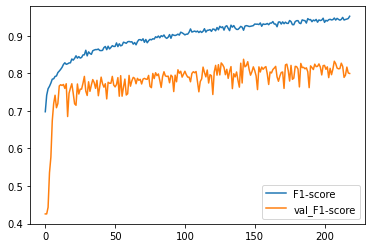

In [ ]:
plt.plot(r.history['f1_m'], label='F1-score')
plt.plot(r.history['val_f1_m'], label='val_F1-score')
plt.legend();

#### Plot Precision per iteration

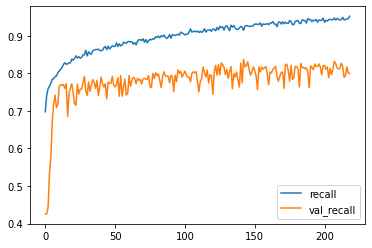

In [ ]:
plt.plot(r.history['recall_m'], label='recall')
plt.plot(r.history['val_recall_m'], label='val_recall')
plt.legend();

#### Plot Recall per iteration

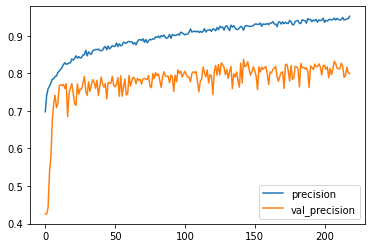

In [ ]:
plt.plot(r.history['precision_m'], label='precision')
plt.plot(r.history['val_precision_m'], label='val_precision')
plt.legend();

#### Plot AUC per iteration

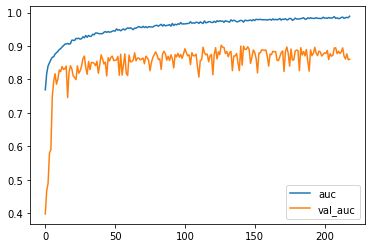

In [ ]:
plt.plot(r.history['auc'], label='auc')
plt.plot(r.history['val_auc'], label='val_auc')
plt.legend();

### Evaluate Model

In [ ]:
val_generator.batch_size=1
score = model.evaluate(val_generator)

1541/1541 [==============================] - 12s 8ms/step - loss: 0.5352 - acc: 0.8222 - f1_m: 0.8222 - precision_m: 0.8222 - recall_m: 0.8222 - auc: 0.8865


In [ ]:
test_generator.batch_size=32
score = model.evaluate(test_generator)

11/11 [==============================] - 2s 133ms/step - loss: 0.4133 - acc: 0.8596 - f1_m: 0.8599 - precision_m: 0.8599 - recall_m: 0.8599 - auc: 0.9182


### Predict over test data

In [ ]:
test_generator.reset()
X_test, y_test = next(test_generator) 
scores = model.predict(test_generator, len(test_generator))

print("------- Scores for test data prediction -------")
print("Loss: ", score[0], "Accuracy: ", score[1])

------- Scores for test data prediction -------
Loss:  0.4132870137691498 Accuracy:  0.8595988750457764


In [ ]:
# Class predicted
predicted_class_indices = np.argmax(scores,axis=1)
print(predicted_class_indices[:10])

[1 1 0 1 0 1 0 1 0 1]


In [ ]:
# Labels predicted
labels = (train_generator.class_indices)
labelss = dict((v,k) for k,v in labels.items())
predictions = [labelss[k] for k in predicted_class_indices]

print(predictions[:10])

['no_bike', 'no_bike', 'bike', 'no_bike', 'bike', 'no_bike', 'bike', 'no_bike', 'bike', 'no_bike']


In [ ]:
# Filenames with labels predicted
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

print(results)

                      Filename Predictions
0    bike/bicicleta (1473).jpg     no_bike
1    bike/bicicleta (1474).jpg     no_bike
2    bike/bicicleta (1475).jpg        bike
3    bike/bicicleta (1476).jpg     no_bike
4    bike/bicicleta (1477).jpg        bike
..                         ...         ...
344     no_bike/moto (165).jpg        bike
345     no_bike/moto (166).jpg     no_bike
346     no_bike/moto (167).jpg        bike
347     no_bike/moto (168).jpg     no_bike
348     no_bike/moto (169).jpg     no_bike

[349 rows x 2 columns]


### Plot Confusion Matrix

Confusion matrix, without normalization
[[13  3]
 [ 2 14]]


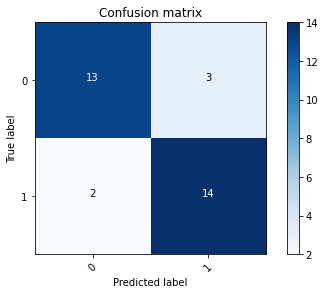

In [ ]:
# Plot confusion matrix
p_test = model.predict(X_test).argmax(axis=1)
orig_test = y_test.argmax(axis=1)
cm = confusion_matrix(orig_test, p_test)
plot_confusion_matrix(cm, list(range(2)))

### Misclassified Images

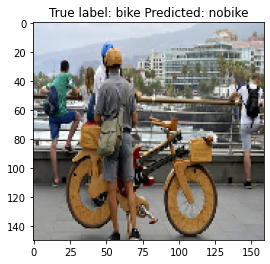

In [ ]:
# label mapping
labels = '''bike
nobike'''.split()

# Show some misclassified examples
misclassified_idx = np.where(p_test != orig_test)[0]
i = np.random.choice(misclassified_idx).astype(int)
plt.imshow(X_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[orig_test[i]], labels[p_test[i]]));

### Predict upload image

In [ ]:
# Upload image
uploaded = files.upload()

Saving bicycle-789648_1920.jpg to bicycle-789648_1920.jpg
Saving bike-190483_640.jpg to bike-190483_640.jpg
Saving bmw-768688_1920.jpg to bmw-768688_1920.jpg
Saving bmw-1313343_1920.jpg to bmw-1313343_1920.jpg
Saving dog-6082017_1920.jpg to dog-6082017_1920.jpg
Saving IMG-20210326-WA0010.jpg to IMG-20210326-WA0010.jpg
Saving IMG-20210326-WA0011.jpg to IMG-20210326-WA0011.jpg
Saving IMG-20210326-WA0012.jpg to IMG-20210326-WA0012.jpg
Saving IMG-20210326-WA0013.jpg to IMG-20210326-WA0013.jpg
Saving IMG-20210326-WA0014.jpg to IMG-20210326-WA0014.jpg
Saving IMG-20210326-WA0015.jpg to IMG-20210326-WA0015.jpg
Saving IMG-20210326-WA0016.jpg to IMG-20210326-WA0016.jpg
Saving IMG-20210326-WA0017.jpg to IMG-20210326-WA0017.jpg
Saving MicrosoftTeams-image (1).png to MicrosoftTeams-image (1) (1).png
Saving MicrosoftTeams-image (2).png to MicrosoftTeams-image (2) (1).png
Saving MicrosoftTeams-image (3).png to MicrosoftTeams-image (3) (1).png
Saving MicrosoftTeams-image (4).png to MicrosoftTeams-imag

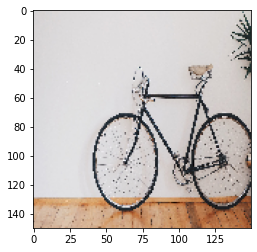

Prediction:  0
Probabilty:  0.9999999
bicycle-789648_1920.jpg is a bike


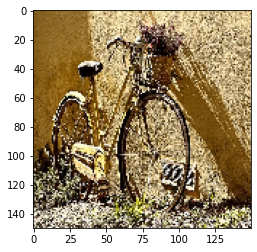

Prediction:  0
Probabilty:  0.99701226
bike-190483_640.jpg is a bike


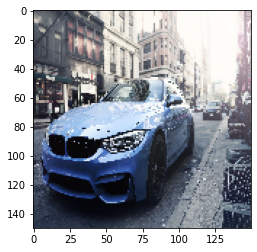

Prediction:  1
Probabilty:  2.2676075e-05
bmw-768688_1920.jpg isn't a bike


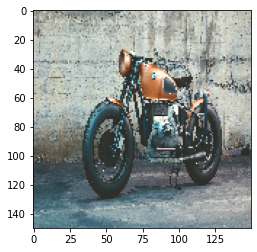

Prediction:  1
Probabilty:  0.116187856
bmw-1313343_1920.jpg isn't a bike


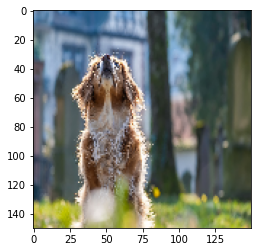

Prediction:  0
Probabilty:  0.95746285
dog-6082017_1920.jpg is a bike


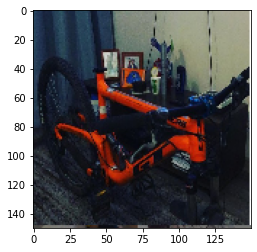

Prediction:  1
Probabilty:  0.00042732805
IMG-20210326-WA0010.jpg isn't a bike


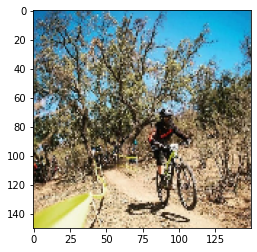

Prediction:  0
Probabilty:  0.99925417
IMG-20210326-WA0011.jpg is a bike


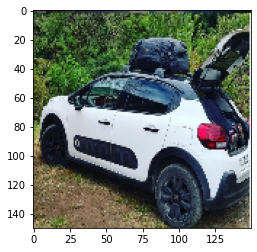

Prediction:  1
Probabilty:  1.3774985e-10
IMG-20210326-WA0012.jpg isn't a bike


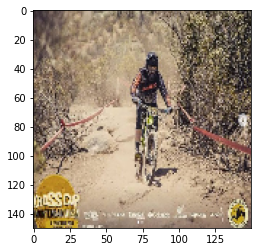

Prediction:  0
Probabilty:  0.99999964
IMG-20210326-WA0013.jpg is a bike


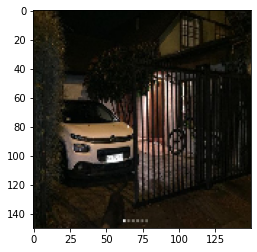

Prediction:  0
Probabilty:  0.8022993
IMG-20210326-WA0014.jpg is a bike


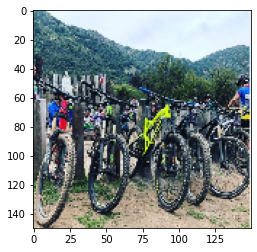

Prediction:  0
Probabilty:  0.99940336
IMG-20210326-WA0015.jpg is a bike


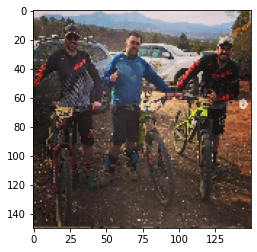

Prediction:  0
Probabilty:  0.9655938
IMG-20210326-WA0016.jpg is a bike


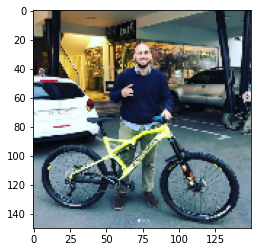

Prediction:  1
Probabilty:  0.0009663399
IMG-20210326-WA0017.jpg isn't a bike


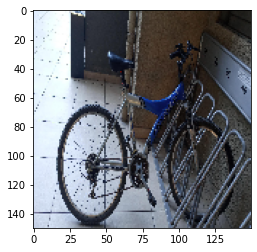

Prediction:  0
Probabilty:  0.99999654
MicrosoftTeams-image (1).png is a bike


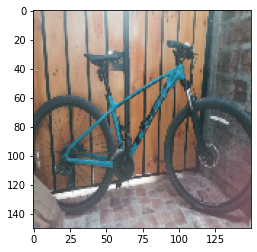

Prediction:  0
Probabilty:  0.9995654
MicrosoftTeams-image (2).png is a bike


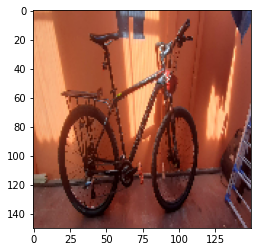

Prediction:  0
Probabilty:  0.99996984
MicrosoftTeams-image (3).png is a bike


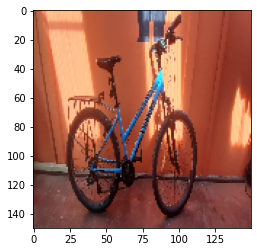

Prediction:  0
Probabilty:  0.99983144
MicrosoftTeams-image (4).png is a bike


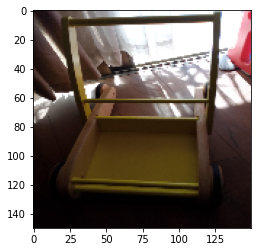

Prediction:  0
Probabilty:  0.9995548
MicrosoftTeams-image.png is a bike


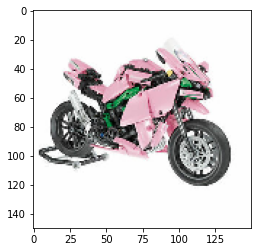

Prediction:  1
Probabilty:  0.00032015383
moto (169).jpg isn't a bike


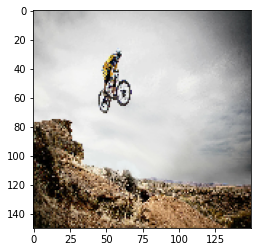

Prediction:  0
Probabilty:  0.9905111
mountain-biking-95032_1920.jpg is a bike


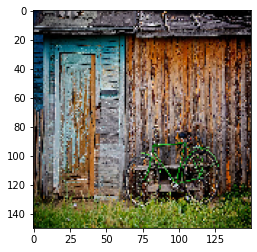

Prediction:  0
Probabilty:  0.9999881
shed-336505_1920.jpg is a bike


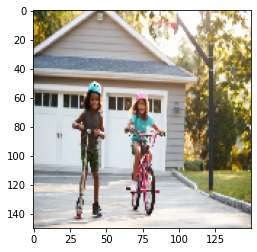

Prediction:  0
Probabilty:  0.9999503
sister-with-brother-riding-scooter-and-bike-on-driveway-at-home-picture-id904506354.jpg is a bike


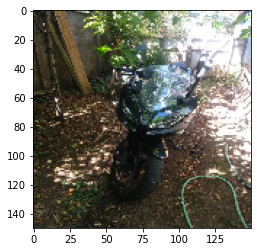

Prediction:  0
Probabilty:  0.99994934
WhatsApp Image 2021-03-27 at 18.22.01 (1).jpeg is a bike


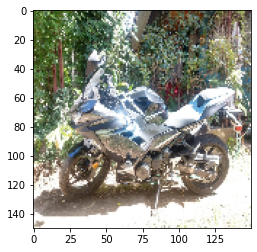

Prediction:  1
Probabilty:  0.0116395475
WhatsApp Image 2021-03-27 at 18.22.01.jpeg isn't a bike


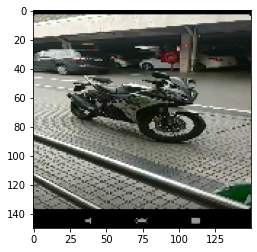

Prediction:  1
Probabilty:  0.37488535
WhatsApp Image 2021-03-27 at 18.22.15.jpeg isn't a bike


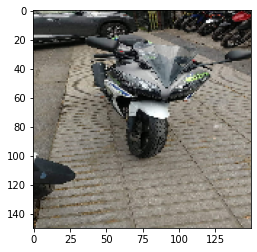

Prediction:  1
Probabilty:  0.027635237
WhatsApp Image 2021-03-27 at 18.22.16 (1).jpeg isn't a bike


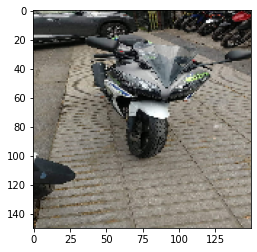

Prediction:  1
Probabilty:  0.027635237
WhatsApp Image 2021-03-27 at 18.22.16.jpeg isn't a bike


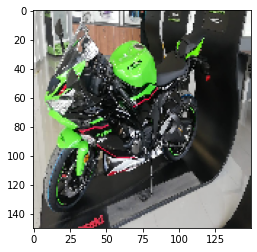

Prediction:  1
Probabilty:  0.0015824657
WhatsApp Image 2021-03-27 at 18.22.33 (1).jpeg isn't a bike


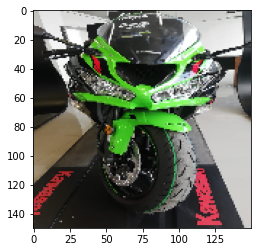

Prediction:  1
Probabilty:  0.03845441
WhatsApp Image 2021-03-27 at 18.22.33.jpeg isn't a bike


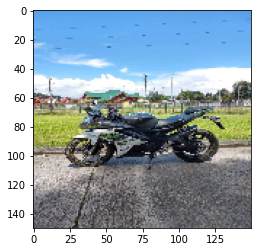

Prediction:  0
Probabilty:  0.9716984
WhatsApp Image 2021-03-27 at 18.23.51.jpeg is a bike


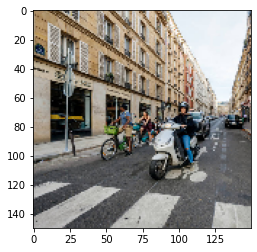

Prediction:  0
Probabilty:  0.9435321
woman-on-scooter-on-parisian-street-picture-id1128757501.jpg is a bike


In [ ]:
from keras.preprocessing import image

# Clasiffier Image
for fn in uploaded.keys():
    
    # predicting images
    path = '/content/' + fn
    img = image.load_img(path, target_size=(150, 150))
    
    plt.imshow(img)
    plt.show();

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    images = images/255.
    
    classes = model.predict(images).argmax(axis=1)
    prob = model.predict(images)[0][0]

    print('Prediction: ', classes[0])
    print('Probabilty: ', prob)
    
    if classes[0] == 0:
        print(fn + " is a bike")        
    else:
        print(fn + " isn't a bike")

### Hyperparameter tuning

#### Callback Definition

In [ ]:
# callback to append loss
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# callback to append AUC
class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        self.losses = []
        self.auc_values = []

    def on_epoch_end(self, epoch, logs={}):
        self.y_p = []
        self.y_v = []
        for i in range(len(val_generator)):
            x_val, y_val = val_generator[i]
            y_pred = self.model.predict(x_val)
            self.y_p.append(y_pred)
            self.y_v.append(y_val)
        self.y_p = np.concatenate(self.y_p)
        self.y_v = np.concatenate(self.y_v)
        roc_auc = roc_auc_score(self.y_v, self.y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        self.losses.append(logs.get('loss'))
        self.auc_values.append(roc_auc)       

#### Tuning with LossHistory Callback

In [ ]:
# range of learning rates to tune
hyper_parameters_for_lr = [0.001, 0.0001, 0.0003, 0.00001]

# instantiate a LossHistory() object to store histories
history = LossHistory()
plot_data = {}

# for each hyperparam: train the model and plot loss history
for lr in hyper_parameters_for_lr:
    print ('\n\n'+'=='*20 + '   Checking for LR={}  '.format(lr) + '=='*20 )
    sgd = Adam(lr=lr)
    
    # model and generators
    model.compile(optimizer = sgd, 
                  loss='binary_crossentropy',
                  metrics=[f1_m, precision_m])
    model.fit(train_generator, 
              validation_data = val_generator, 
              steps_per_epoch=step_size_train, 
              validation_steps=step_size_valid, 
              epochs=20, 
              verbose=2,
              callbacks=[history])
    
    # plot loss history
    plot_data[lr] = history.losses



========================================   Checking for LR=0.001  ========================================
Epoch 1/20
77/77 - 87s - loss: 0.3111 - f1_m: 0.8649 - precision_m: 0.8649 - val_loss: 0.3202 - val_f1_m: 0.9167 - val_precision_m: 0.9167
Epoch 2/20
77/77 - 86s - loss: 0.2942 - f1_m: 0.8632 - precision_m: 0.8632 - val_loss: 0.5113 - val_f1_m: 0.7917 - val_precision_m: 0.7917
Epoch 3/20
77/77 - 87s - loss: 0.2929 - f1_m: 0.8688 - precision_m: 0.8688 - val_loss: 0.6389 - val_f1_m: 0.7917 - val_precision_m: 0.7917
Epoch 4/20
77/77 - 87s - loss: 0.3033 - f1_m: 0.8653 - precision_m: 0.8653 - val_loss: 0.6291 - val_f1_m: 0.7500 - val_precision_m: 0.7500
Epoch 5/20
77/77 - 87s - loss: 0.2911 - f1_m: 0.8709 - precision_m: 0.8709 - val_loss: 0.3404 - val_f1_m: 0.8333 - val_precision_m: 0.8333
Epoch 6/20
77/77 - 87s - loss: 0.2801 - f1_m: 0.8740 - precision_m: 0.8740 - val_loss: 0.9850 - val_f1_m: 0.5833 - val_precision_m: 0.5833
Epoch 7/20
77/77 - 87s - loss: 0.2835 - f1_m: 0.8706 - pr

##### Learning Rate performance for loss

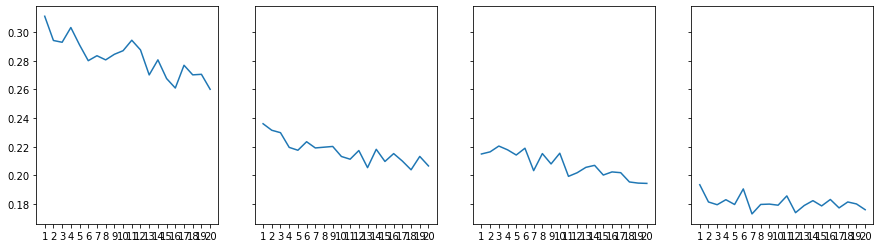

In [ ]:
# plot loss history for each value of hyperparameter
f, axes = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)

plt.setp(axes, xticks=np.arange(0, len(plot_data[0.0001]), 1)+1)

for i, lr in enumerate(plot_data.keys()):
    axes[i].plot(np.arange(len(plot_data[lr]))+1, plot_data[lr])

#### Tuning with roc_callback

In [ ]:
# range of learning rates to tune
hyper_parameters_for_lr = [0.001, 0.0001, 0.0003, 0.00001]

# instantiate a LossHistory() object to store histories
auc_logger = roc_callback()
plot_data = {}

# for each hyperparam: train the model and plot loss history
for lr in hyper_parameters_for_lr:
    print ('\n\n'+'=='*20 + '   Checking for LR={}  '.format(lr) + '=='*20 )
    sgd = Adam(lr=lr)
    
    # model and generators
    model.compile(optimizer = sgd, 
                  loss='binary_crossentropy',
                  metrics=[f1_m, precision_m])
    model.fit(train_generator, 
              validation_data = val_generator, 
              steps_per_epoch=step_size_train, 
              validation_steps=step_size_valid, 
              epochs=20, 
              verbose=2,
              callbacks=[auc_logger])
    
    # plot loss history
    plot_data[lr] = auc_logger.auc_values



========================================   Checking for LR=0.001  ========================================
Epoch 1/20
77/77 - 83s - loss: 0.2416 - f1_m: 0.8923 - precision_m: 0.8923 - val_loss: 0.4701 - val_f1_m: 0.7917 - val_precision_m: 0.7917

Val AUC for epoch0: 0.8858860410638004
Epoch 2/20
77/77 - 81s - loss: 0.2284 - f1_m: 0.9007 - precision_m: 0.9007 - val_loss: 0.3638 - val_f1_m: 0.8333 - val_precision_m: 0.8333

Val AUC for epoch1: 0.886099197326719
Epoch 3/20
77/77 - 81s - loss: 0.2421 - f1_m: 0.8913 - precision_m: 0.8913 - val_loss: 0.4320 - val_f1_m: 0.7917 - val_precision_m: 0.7917

Val AUC for epoch2: 0.8855381011437233
Epoch 4/20
77/77 - 80s - loss: 0.2347 - f1_m: 0.8996 - precision_m: 0.8996 - val_loss: 0.4044 - val_f1_m: 0.8750 - val_precision_m: 0.8750

Val AUC for epoch3: 0.8914298263745348
Epoch 5/20
77/77 - 81s - loss: 0.2323 - f1_m: 0.8959 - precision_m: 0.8959 - val_loss: 1.0246 - val_f1_m: 0.7083 - val_precision_m: 0.7083

Val AUC for epoch4: 0.87251188507647

##### Learning Rate performance for AUC

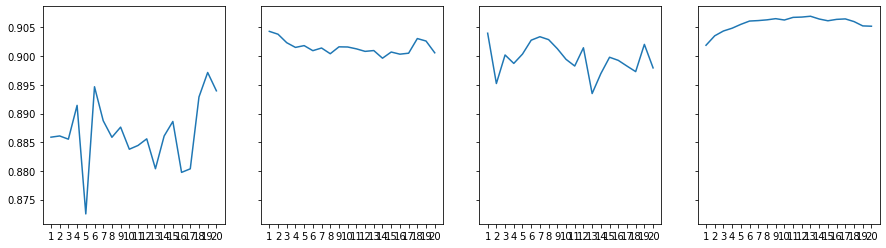

In [ ]:
# plot AUC values for each value of hyperparameter
f, axes = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)

plt.setp(axes, xticks=np.arange(0, len(plot_data[0.001]), 1)+1)

for i, lr in enumerate(plot_data.keys()):
    axes[i].plot(np.arange(len(plot_data[lr]))+1, plot_data[lr])

In [ ]:
print('--- end ---')

--- end ---
